# DP3: Control of a Spacecraft with Reaction Wheels and a Star Tracker
by Conan Zhang and 
Kareef Haque

## Introduction

Star trackers are a critical element of navigation systems in spacecraft. One main application is their use in determining the orientation of a satellite with respect to stars. With a designated observation, the satellite can both maintain its stability in space while enabling high-quality image capture. This notebook details the development of a spacecraft fitted with four reaction wheels and a star-tracker sensor that tracks the $y,z$ coordinates of 8 stars in a letter $I$ configuration. As the spacecraft is hit with flying debris, it must maintain some chosen orientation relative to the stars through applied torques on the reaction wheels, denoted as $\tau_{1,2,3,4}$. This notebook's objective is to thus explain the steps towards developing an optimal control system that keeps the spacecraft at a constant orientation within a margin of error. This process involves linearizing the equations of motion for approximation, demonstrating system controllability, designing and testing the controller-observer system, defining requirements, and documenting results for evaluating compliance with the established requirements. For this design, a reliable controller and observer system should be developed, and the system should meticulously be tested to verify ity requirements. 

## Theory

To begin, all packages are imported into the notebook. *numpy* and *sympy* help build the equation of motions and linearize the system model providing a foundation for the controller design. *scipy* is utilized when finding optimal gain matrices for the controller/observer. *matplotlib.pyplot* helps with plotting the motion of the spacecraft and verifying the system requirements with visual analysis.

In [87]:
import numpy as np
from sympy import *
from scipy import linalg
import matplotlib.pyplot as plt

import ae353_spacecraft
from ae353_spacecraft import get_star_coords
star_coords = get_star_coords()
star_coords

{'alpha': array([-0.06,  0.  ,  0.06,  0.  ,  0.  , -0.06,  0.  ,  0.06]),
 'delta': array([-0.09, -0.09, -0.09, -0.03,  0.03,  0.09,  0.09,  0.09])}

The spacecraft project function *get_star_coords* must also be imported. This function returns a dictionary consisting of alpha ($\alpha$): the right ascension of the star and delta ($\delta$): the declination of the i-th star in radians, together representing the star’s equatorial celestial coordinates in the constellation. In total, 8 stars in the shape of the letter I are observed for their measured positions while the controller maintains the view of the stars.

### Dynamic Model Creation

All variables used in the system must be defined to design the controller and observer. The state variables include $\phi$, $\theta$, $\psi$, $\omega_x$, $\omega_y$, $\omega_z$ while the input variables include $\tau_1$, $\tau_2$, $\tau_3$, $\tau_4$. The system parameters (constants) defining the bus and wheels of the spacecraft are also defined below. 

In [88]:
phi = symbols('phi')          # roll angle (rad)
theta = symbols('theta')      # pitch angle (rad)
psi = symbols('psi')          # yaw angle (rad)                      
wx_inB = symbols('omega_x')   # angular velocity about the body-fixed x-axis (rad/s) 
wy_inB = symbols('omega_y')   # angular velocity about the body-fixed y-axis (rad/s) 
wz_inB = symbols('omega_z')   # angular velocity about the body-fixed z-axis (rad/s) 
tau_1 = symbols('tau_1')      # torque applied to Reaction Wheel 1 by a motor on the spacecraft (N.m)
tau_2 = symbols('tau_2')      # torque applied to Reaction Wheel 2 by a motor on the spacecraft (N.m)
tau_3 = symbols('tau_3')      # torque applied to Reaction Wheel 3 by a motor on the spacecraft (N.m)
tau_4 = symbols('tau_4')      # torque applied to Reaction Wheel 4 by a motor on the spacecraft (N.m)
alpha_i = symbols('alpha_i')  # right ascension of the i-th star (rad)
delta_i = symbols('delta_i')  # declination of the i-th star (rad)

In [89]:
mb = 6.       # mass of the bus
Ixxb = 10.    # moment of inertia of the bus about x-axis
Iyyb = 10.    # moment of inertia of the bus about y-axis
Izzb = 16.    # moment of inertia of the bus about z-axis
rb = 2.2      # radius of the bus
mw = 1.       # mass of each wheel
Ixxw = 0.075  # moment of inertia of each wheel about x-axis
Iyyw = 0.075  # moment of inertia of each wheel about x-axis
Izzw = 0.125  # moment of inertia of each wheel about x-axis

The change_of_coords function converts a vector in coordinate frame A to a coordinate frame B where the orientation of A in B is described by the set of angles: roll, pitch, yaw.

In [90]:
def change_of_coords(v_inA, roll, pitch, yaw):
    # Derives the rotation matrices from the roll, pitch, and yaw values
    cx = np.cos(roll)
    sx = np.sin(roll)
    cy = np.cos(pitch)
    sy = np.sin(pitch)
    cz = np.cos(yaw)
    sz = np.sin(yaw)
    Rx = np.array([[1., 0., 0.],[0., cx, -sx],[0., sx, cx]])
    Ry = np.array([[cy, 0., sy],[0., 1., 0.],[-sy, 0., cy]])
    Rz = np.array([[cz, -sz, 0.],[sz, cz, 0.],[0., 0., 1.]])

    # Combines the individual rotations into a single transformation
    R_ofA_inB = Rz@Ry@Rx

    # Applies the transformation on the vector in frame A
    v_inB = R_ofA_inB @ v_inA

    # Ouputs same vector in frame B
    return v_inB

Next, the equations of motion for the bus and the wheels are created using the variables, constants, and change_of_coords function. Because the torques on the bus are in the opposite direction as the torques applied to the wheels due to Newton's Third Law, the total torque on the spacecraft is the negative sum of $\tau_1$, $\tau_2$, $\tau_3$, and $\tau_4$. The torques applied to spacecraft in spacecraft-fixed coordinates is found to be *tau_inB*.


In [91]:
# Defines the angular velocity vector written in body coordinates
w_inB = Matrix([[wx_inB],[wy_inB],[wz_inB]])

# Defines roll, pitch, and yaw rotation matrices that describe the bus's orientation in the world frame
Rx = Matrix([[1,0,0],[0,cos(phi),-sin(phi)],[0,sin(phi),cos(phi)]])
Ry = Matrix([[cos(theta),0,sin(theta)],[0,1,0],[-sin(theta),0,cos(theta)]])
Rz = Matrix([[cos(psi),-sin(psi), 0],[sin(psi),cos(psi),0],[0,0,1]])

# Multiplies torque scalars by their directions (in each wheel's frame) to get the torque applied to each wheel as a vector
t1_inT1 = tau_1 * Matrix([[0.],[0.],[1.]])
t2_inT2 = tau_2 * Matrix([[0.],[0.],[1.]])
t3_inT3 = tau_3 * Matrix([[0.],[0.],[1.]])
t4_inT4 = tau_4 * Matrix([[0.],[0.],[1.]])

# Changes the torque on the wheel vectors from their own body coordinates to bus coordinates
t1_inB = change_of_coords(t1_inT1, 0.,       0., 1.570796)
t2_inB = change_of_coords(t2_inT2, 2.094395, 0., 2.617994)
t3_inB = change_of_coords(t3_inT3, 2.094395, 0., 4.712389)
t4_inB = change_of_coords(t4_inT4, 2.094395, 0., 0.523599)

# Sums the torque vectors to get the total torque on the spacecraft by the wheels in bus coordinates.
tau_inB = -t1_inB - t2_inB - t3_inB - t4_inB
tau_inB = simplify(tau_inB)

The parallel axis theorem is then used to convert the moment's of inertia about each wheel's center to the center of the bus. Each wheel can be assumed to have 0 moment of inertia and thus treated as a point mass due to the moment of inertia about each wheel compared to the inertia imposed by their location being small. The moment of inertia matrix of the spacecraft written in principal axes is found to be *I_inB*.

In [92]:
# Obtains the position of the center of mass of each wheel in bus coordinates
p1_inB = np.round(np.array(rb*(t1_inB/tau_1)).astype(np.float64).flatten(),6)
p2_inB = np.round(np.array(rb*(t2_inB/tau_2)).astype(np.float64).flatten(),6)
p3_inB = np.round(np.array(rb*(t3_inB/tau_3)).astype(np.float64).flatten(),6)
p4_inB = np.round(np.array(rb*(t4_inB/tau_4)).astype(np.float64).flatten(),6)
ps_inB = [p1_inB, p2_inB, p3_inB, p4_inB]

# Calculates the total moment of inertia
Ixx = Ixxb
Iyy = Iyyb
Izz = Izzb
for p_inB in ps_inB:
    # Gets the distance from the x axis and the resultant point inertia
    dx = np.linalg.norm(p_inB[1:])
    ixx = mw * dx**2
    Ixx = Ixx + ixx
    
    # Gets the distance from the y axis and the resultant point inertia
    dy = np.linalg.norm(p_inB[0:3:2])
    iyy = mw * dy**2
    Iyy = Iyy + iyy
    
    # Gets the distance from the z axis and the resultant point inertia
    dz = np.linalg.norm(p_inB[0:2])
    izz = mw * dz**2
    Izz = Izz + izz

# Assembles the moment of inertia matrix
I_inB = Matrix([[Ixx, 0.,  0],[0.,  Iyy, 0.],[0.,  0.,  Izz]])

Using [Euler's Equations](https://en.wikipedia.org/wiki/Euler%27s_equations_(rigid_body_dynamics)), the equations of motion that combine the spacecraft's differential equations into a single system of equations can be created. This includes the time derivative of the angular velocities and the angular velocities themselves. These equations are derived in terms of the variables defined previously.

In [93]:
# Creates time derivative of the angular velocities in the spacecraft-fixed frame
w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
w_inB_dot = simplify(w_inB_dot)

# Defines the transformation that takes roll, pitch, and yaw rates to body-fixed angular rates
ex = Matrix([[1], [0], [0]])
ey = Matrix([[0], [1], [0]])
ez = Matrix([[0], [0], [1]])
M = Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

# Inverts the transformation to get a matrix that takes body-fixed angular rates to roll, pitch, and yaw rates
M_inv = simplify(M.inv())

# Converts the body-fixed angular rates to roll, pitch, and yaw rates
rpy_dot = simplify(M_inv@w_inB)

# Assembles the system of equations
f = simplify(Matrix.vstack(rpy_dot, w_inB_dot))
N(f,3)

Matrix([
[                 omega_x + omega_y*sin(phi)*tan(theta) + omega_z*cos(phi)*tan(theta)],
[                                                 omega_y*cos(phi) - omega_z*sin(phi)],
[                                    (omega_y*sin(phi) + omega_z*cos(phi))/cos(theta)],
[                 -0.124*omega_y*omega_z - 0.0181*tau_2 + 0.0362*tau_3 - 0.0181*tau_4],
[                 0.124*omega_x*omega_z - 0.0314*tau_2 + 7.1e-10*tau_3 + 0.0314*tau_4],
[-2.37e-8*omega_x*omega_y - 0.0372*tau_1 + 0.0186*tau_2 + 0.0186*tau_3 + 0.0186*tau_4]])

The final dynamic model is now represented in the form below.

$$\begin{bmatrix} \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \\ \dot{\omega_x} \\ \dot{\omega_y} \\ \dot{\omega_z} \end{bmatrix}=f\left(\phi, \theta, \psi, \omega_x, \omega_y, \omega_z, \tau_1, \tau_2, \tau_3, \tau_4\right)$$

### Sensor Model Creation

In creating the sensor model, a new system of equations relating the sensed states to the states used in the system dynamics must be created. The stars are created using the ascension $\alpha$ and the declination $\delta$ defined previously. Using the [equitorial celestial coordinate system](https://en.wikipedia.org/wiki/Equatorial_coordinate_system), the star coords are next used to calculate the $i$th star's location in the scope image using a pinhol camera model. Dividing the $y$ and $z$ coordinates by the $x$ coordinate allows for all constants to drop out.

In [94]:
# Calculates the depth normalized cartesian coordinates of the ith star in the fixed world coorinates using the equitorial celestial coordinates
p_ofi_inW = Matrix([[cos(alpha_i)*cos(delta_i)], [sin(alpha_i)*cos(delta_i)], [sin(delta_i)]])

# Calculates the orientation of the spacecraft using it's roll, pitch, and yaw angles
R_ofS_inW = simplify(Rz @ Ry @ Rx)

# Inverts the orientation of the spacecraft to get a transform that takes vectors in world coordinates to vectors in spacecraft-fixed coordinates.
R_ofW_inS = R_ofS_inW.T # (inverse = tranpose for a rotation matrix)

# Obtains the position of the ith star in spacecraft-fixed coordinates
p_ofi_inS = simplify(R_ofW_inS @ p_ofi_inW)

# Defines the radius of the star scope
rc = 0.8/2.1

# Calculate the star scope coordinates, q,  of the ith star
g_num = simplify( (1/rc) * Matrix([[p_ofi_inS[1] / p_ofi_inS[0]],
                                       [p_ofi_inS[2] / p_ofi_inS[0]]]) )
g_num

Matrix([
[2.625*(sin(delta_i)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta_i)*cos(alpha_i - psi) + sin(alpha_i - psi)*cos(delta_i)*cos(phi))/(-sin(delta_i)*sin(theta) + cos(delta_i)*cos(theta)*cos(alpha_i - psi))],
[2.625*(sin(delta_i)*cos(phi)*cos(theta) - sin(phi)*sin(alpha_i - psi)*cos(delta_i) + sin(theta)*cos(delta_i)*cos(phi)*cos(alpha_i - psi))/(-sin(delta_i)*sin(theta) + cos(delta_i)*cos(theta)*cos(alpha_i - psi))]])

The final sensor model for each star is now represented in the form below where $q_i$ is the star scope coordinates of the $i$th star.

$$
q_i = g(\phi, \theta, \psi, \alpha_{i}, \delta_{i}),
$$

### System Linearization and State Space Form

Deriving the models for both the controller and observer, the next step is to linearize the dynamic model (i.e., the equations of motion) and the sensor model. Through linearization, the complex equations of motion of the system and the non-linearity of the sensor can be simplified, enabling more thorough analysis on the system’s behavior under varying conditions. The following linearized equations represent the system. 

\begin{equation}
\dot{x} = Ax + Bu
\end{equation}

\begin{equation}
y = Cx + Du
\end{equation}

The system can now begin the linearization process. $x$ and $u$ represent the state and input respectively for the state-space model.
$$
\begin{matrix}
x = \begin{bmatrix}
m - m_e
\end{bmatrix}
&
u = \begin{bmatrix}
n - n_e
\end{bmatrix}
\end{matrix}
$$

The column vectors $m$ and $n$ represent the states and inputs respectively. 

$$
\begin{matrix} 
m = \begin{bmatrix}
\phi \\
\theta \\
\psi \\
\omega_x \\
\omega_y \\
\omega_z 
\end{bmatrix}
&
n = \begin{bmatrix}
\tau_1 \\
\tau_2 \\
\tau_3 \\
\tau_4 
\end{bmatrix}
\end{matrix}
$$

#### Controller Design

Starting with the controller, the state-space model can be derived using the dynamic model found earlier. Equilibrium points are first defined and used to linearize the system where $f(m,n)$ = 0. The chosen equilibrium points for the spacecraft were all set to a value of 0. Values of 0 for all state and input variables were chosen to stabilize the state-space system around a steady state while keeping the controller controllable. 

In [95]:
#equilibrium points
phi_e = theta_e = psi_e = w_x_e = w_y_e = w_z_e = tau_1_e = tau_2_e = tau_3_e = tau_4_e = 0

The next step is to place the space-space model into state feedback form. By taking the Jacobian of the dynamic model with respect to the state variables and control inputs, the coefficient matrices $A$ and $B$ can be found (A_num and B_num). The result is a linear approximation of the right-hand side of the first-order differential equations. Plugging in the equilibrium points found earlier, a linearized state-space model is derived where $A$ is a 6x6 matrix and $B$ is a 6x4 matrix.

In [96]:
#solving for A
A_num = lambdify([phi, theta, psi, wx_inB, wy_inB, wz_inB, tau_1, tau_2, tau_3, tau_4], f.jacobian([phi, theta, psi, wx_inB, wy_inB, wz_inB]))
A = A_num(phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)
print(A.shape)
Matrix(A)

(6, 6)


Matrix([
[0, 0, 0, 1.0,   0,   0],
[0, 0, 0,   0, 1.0,   0],
[0, 0, 0,   0,   0, 1.0],
[0, 0, 0,   0,   0,   0],
[0, 0, 0,   0,   0,   0],
[0, 0, 0,   0,   0,   0]])

In [97]:
#solving for B
B_num = lambdify([phi, theta, psi, wx_inB, wy_inB, wz_inB, tau_1, tau_2, tau_3, tau_4], f.jacobian([tau_1, tau_2, tau_3, tau_4]))
B = B_num(phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)
print(B.shape)
Matrix(B)

(6, 4)


Matrix([
[                  0,                   0,                    0,                   0],
[                  0,                   0,                    0,                   0],
[                  0,                   0,                    0,                   0],
[                  0, -0.0181063197149959,   0.0362126470826273, -0.0181063305787912],
[                  0, -0.0313610736839173, 7.10322282429955e-10,  0.0313610674117016],
[-0.0371885450450875,  0.0185942692248454,   0.0185942692248454,  0.0185942692248454]])

The final state-space model is now in the form:
\begin{equation}
\dot{x} = Ax + Bu
\end{equation}

#### Observer Design

Since the exact values of the state variables in $x$ are not directly measurable, implementing a star tracker observer is essential for deriving a state estimate $\hat{x}$ in real-time. This estimate is crucial as it provides the feedback needed to track the celestial coordinates accurately. The star coordinate positions, which the controller relies on to maintain the field of view, are estimated and corrected based on this feedback. When designing an observer for such a system, the linear output $y$ is represented by the output equation below.

\begin{equation}
y = q_i - g(m_e, n_e)
\end{equation}

Star-scope cooordinates ($q_i$) are described by a function of $g$ with respect to the state variables and control inputs. Simplifying $q_i$, results in a dependency on only $\phi$, $\theta$, $\psi$, $\alpha$, $\delta$.

$$
q_i = g(\phi, \theta, \psi, \alpha_{i}, \delta_{i})
$$
$$
\begin{bmatrix}
y_{\text{i}} \\
z_{\text{i}} \\
\end{bmatrix} = 
g(\psi, \theta, \phi, \alpha, \delta)
$$

The following for-loop iterates over each star coordinate to linearize the function $g$ representing the sensor model. For each coordinate pair, $\alpha$ and $\delta$ are defined and plugged into sensor model $g$. On the first iteration, the Jacobian of $g$ is taken at the first coordinate and evaluated at the equilibrium points producing matrix $C_1$. The the following iterations, the Jacobian of $g$ is taken for the rest of the star coordinates and evaluated at their respective equilibriums, resulting in a stacked collection of Jacobians (Matrix $C$).

The equilibrium points for the linearization of each $g$ to make $g(m,n) = 0$ were chosen as shown. 
$$
\begin{bmatrix}
\phi_e \\
\theta_e \\
\psi_e \\
\end{bmatrix} = 
\begin{bmatrix}
0 \\
-\delta_i \\
\alpha_i \\
\end{bmatrix} 
$$

In [98]:
star_coords = np.array([[-0.06,  0.  ,  0.06,  0.  ,  0.  , -0.06,  0.  ,  0.06], [-0.09, -0.09, -0.09, -0.03,  0.03,  0.09,  0.09,  0.09]])
for i in range(0,len(star_coords[0])):
    # Plugging in alpha_i and delta_i into g
    alpha_e = star_coords[0][i]
    delta_e = star_coords[1][i]
    # Creating C matrix
    if i == 0:
        C_num = lambdify([phi, theta, psi, alpha_i, delta_i], g_num.jacobian([phi, theta, psi, wx_inB, wy_inB, wz_inB]))
        C = C_num(phi_e, theta_e, psi_e, alpha_e, delta_e)
    else:
        C = np.concatenate([C, C_num(phi_e, theta_e, psi_e, alpha_e, delta_e)])
print(C.shape)
Matrix(C)

(16, 6)


Matrix([
[ -0.237316990961119,  0.0142561309219474,   -2.63447272635414, 0, 0, 0],
[  0.157689272557155,    2.64645499207575, -0.0142561309219474, 0, 0, 0],
[ -0.236889948513187,                   0,              -2.625, 0, 0, 0],
[                  0,    2.64637784674536,                   0, 0, 0, 0],
[ -0.237316990961119, -0.0142561309219474,   -2.63447272635414, 0, 0, 0],
[ -0.157689272557155,    2.64645499207575,  0.0142561309219474, 0, 0, 0],
[-0.0787736335080994,                   0,              -2.625, 0, 0, 0],
[                  0,    2.62736391822326,                   0, 0, 0, 0],
[ 0.0787736335080994,                   0,              -2.625, 0, 0, 0],
[                  0,    2.62736391822326,                   0, 0, 0, 0],
[  0.237316990961119, -0.0142561309219474,   -2.63447272635414, 0, 0, 0],
[  0.157689272557155,    2.64645499207575,  0.0142561309219474, 0, 0, 0],
[  0.236889948513187,                   0,              -2.625, 0, 0, 0],
[                  0,    2.64

The end result is a matrix $C$ of shape (16, 6), indicating that the function $g$ has been linearized at 16 different points corresponding to 8 star coordinates. Since matrix $g$ is independent of the reaction wheel torques $\tau_1$, $\tau_2$, $\tau_3$, $\tau_4$, the resulting $D$ matrix will consist only of 0's. The final linearized model of the non-linear sensor model can thus be represented in the form:
\begin{equation}
y = Cx
\end{equation}

### Controllability Tests

To test for controllability for the controller, controllability matrix $W_c$ can be derived from $A$ and $B$. $W_c$ is a $n \times (n \times m)$ matrix where $n$ is the number of columns of $A$ and $m$ is the number of columns of $B$. Each column of $W_c$ is obtained through matrix multiplication $A^i \times B$ where $i$ is the order of column between 0 and n-1.

$$
W_c = \begin{bmatrix}
B & AB & ... & A^{n-i} B
\end{bmatrix}
$$

In [99]:
#Controllability Test for the Controller
n = np.shape(A)[0]
Wc = B
for i in range(1,n):
    col = np.linalg.matrix_power(A,i)@B
    Wc = np.block([Wc,col])
print(Wc.shape)
print(np.linalg.matrix_rank(Wc) == n)

(6, 24)
True


Similarly for controllability for the observer, controllability matrix $W_o$ can be derived from $A$ and $C$. $W_o$ is a $(n \times m) \times n$ matrix where $n$ is the number of rows of $A$ and $m$ is the number of rows of $C$. Each row of $W_o$ is obtained through matrix multiplication $C \times A^i$ where $i$ is the order of column between 0 and n-1.

$$
W_o = \begin{bmatrix}
C \\
CA \\
\vdots \\
CA^{n-i} \\
\end{bmatrix}
$$

In [100]:
#Controllability Test for the Observer
n = np.shape(A)[0]
Wo = C
for i in range(1,n):
    col = C@np.linalg.matrix_power(A,i)
    Wo = np.block([[Wo],[col]])
print(Wo.shape)
print(np.linalg.matrix_rank(Wo) == n)

(96, 6)
True


Known as full-rank, since the rank of $W_c$ is equal to $n$ and the rank of $W_o$ is also equal to $n$, then every state of the system can be influenced by the control inputs or in this case, the state estimate $\hat{x}$ due to the controller design being based on the sensor measurements. The system is thus fully controllable. 

## Optimal Gains Selection

The Linear Quadratic Regulator (LQR) method is applied to optimize the controller and observer design. This method balances effort and error with weighted matrices $Q$ and $R$. $Q$ is a symmetric matrix where the diagonal elements correspond to the system's state variables $m$. $R$ is also a symmetric matrix where the diagonal elements correspond to each control input $n$. The magnitude of the diagonal element indicates which variable yields greater importance when selecting a gains matrix. The LQR method allows for prioritizing certain weights of specific variables in the state-space models, while also holding the system to eigenvalues with negative real parts. Negative real part eigenvalues suggest that the system will be asymptotically stable returning to equilibrium.

\begin{aligned}
& \text{minimize}
& & \int_{t_0}^{\infty} \left( x(t)^T Q x(t) + u(t)^T R u(t) \right) dt \\
& \text{subject to}
& & \dot{x}(t) = A x(t) + B u(t), \quad x(t_0) = x_0
\end{aligned}

\begin{equation}
A^T P + PA - PBR^{-1}B^T P + Q = 0
\end{equation}

\begin{equation}
K = R^{-1}B^T P
\end{equation}

The problem above illustrates the infinite-horizon time-invariant LQR problem. Solving the continuous-time algebraic Riccati equation for $P$ and the gain matrix equation yields a gains matrix $K$ that minimizes the cost function and achieves desirable controller conditions. Shown below is the function with inputs matrices $A$ and $B$ and weights $Q$ and $R$ returning the optimal gains matrix.

In [101]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @ B.T @ P
    return K

For the linear state feedback controller, state feedback is defined as $u = -Kx$, where $K$ represents the controller gains. The weights of Qc were chosen to prioritize aligning the spacecraft's orientation and angular velocity with equilibrium. The weights of Rc were chosen to ensure that the wheels could iniate enough torque control on the spacecraft orientation without being too aggressive. Implementing the weights into the LQR function yields a 4x6 gains matrix $K$ below that theoretically produces an asymptotically stable closed loop system for the controller design.

In [116]:
Qc = np.diag([1000, 1000, 100, 5, 5, 5])
Rc = np.diag([1, 1, 1, 1])
K = lqr(A, B, Qc, Rc)
print(K.shape)
Matrix(K)

(4, 6)


Matrix([
[-1.70965376014417e-7, -2.96120808307986e-7, -7.55929003474527, -4.19112465952434e-7, -7.25924306610889e-7, -15.3350893663367],
[   -12.9099424368758,     -22.360682523951,  3.77964401696281,    -15.4435240494248,    -26.7489761942074,  7.66754250709913],
[    25.8198882970048,   1.9764157688018e-6,   3.7796445120962,     30.8870511511388,   3.3380262744309e-6,  7.66754373144179],
[   -12.9099478932621,     22.3606770260443,   3.7796445120962,    -15.4435292119578,     26.7489692011305,  7.66754373144179]])

In designing the observer, state error defined as $x_{err} = \hat{x} - x$ can be used to find gains matrix $L$. An ideal observer performance would have $x_{err}$ decay to a value of 0 as time approaches infinity as the estimated state should theoretically be equal to the actual state. Similarly when finding $K$ for the controller, an analogous LQR method can be implemented to find $L$. The weights of $Q$ (inverse of $Ro$) were chosen to minimize the uncertainties/disturbances in the dynamics of the system. The weights of $R$ (inverse of $Qo$) were chosen to minimize the measurement noise in the sensor measurements. Deriving for the error dynamics equation from previous system dynamics and the observer state equation, the equation below is found. The matrix expression $A-LC$ governing the equation can then be reordered into the form $A^T - C^TL^T$ to implement into the LQR function. $L$ must also have negative real part eigenvalues to ensure asymptotic stability in the system.
$$\dot{\hat{x}}_{\text{err}} = (A - LC)\hat{x}_{\text{err}}$$


In [117]:
Ro = np.diag([1,1,1,1,1,1])
Qo = np.diag([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01])

L = lqr(A.T,C.T,np.linalg.inv(Ro),np.linalg.inv(Qo))
L = L.T
print(L.shape)
Matrix(L)

(6, 16)


Matrix([
[   -0.19657972432532,     0.130620709468817,    -0.196225986961848,   7.523961791394e-16,     -0.19657972432532,   -0.130620709468816,     -0.06525154012956, 7.46990296835763e-16,    0.0652515401295615, 7.46990296835763e-16,     0.196579724325322,    0.130620709468817,      0.19622598696185,   7.523961791394e-16,    0.196579724325322,    -0.130620709468816],
[0.000365850831161903,    0.0679151842659858, -2.22746204897698e-16,   0.0679132045084066,  -0.00036585083116235,   0.0679151842659857, -1.77791886898195e-16,   0.0674252557380458, -1.32999355898653e-16,   0.0674252557380458, -0.000365850831162215,   0.0679151842659858, -8.80450378991507e-17,   0.0679132045084066, 0.000365850831162038,    0.0679151842659857],
[ -0.0680266289175835, -0.000368117884966535,   -0.0677820267874933, 1.56661154266674e-16,   -0.0680266289175835, 0.000368117884966849,   -0.0677820267874934, 1.55535561414134e-16,   -0.0677820267874934, 1.55535561414134e-16,   -0.0680266289175836,  0.000368117884966

The resulting observer design along with the controller can be modeled by the equations below. Both gains matrices produce negative real part eigenvalues. Thus, since both the controller and obsever are asymptotically stable and controllable individually, they should theoreticallly work in controlling/observing the system together along the equilibrium points.

\begin{equation}
\dot{\hat{x}} = A\hat{x} + Bu - L(C\hat{x} - y)
\end{equation}

\begin{equation}
u = -K\hat{x}
\end{equation}

In [118]:
K_vals = linalg.eigvals(A-B@K)
L_vals = linalg.eigvals(A-L@C)

print((K_vals.real < 0).all())
print((L_vals.real < 0).all())

True
True


## Experimental Methods

In theoretical analysis, it was established that the controller/observer system developed was both controllable and observable. The subsequent action is to now integrate this controller and observer system into a physics simulator using Meshcat. To evaluate the impact of the created controller, specific criteria must be defined for the spacecraft to fulfill:
- The spacecraft shall maintain a pitch, roll, and yaw angle of between -3° and 3° within 8 seconds until a simulation endpoint is reached: 
  - Any star leaves the star tracker's field of view.
  - Any reaction wheel has angular velocity that exceeds 50 rad/sec.
  - There is no more debris left in the debris field.

Having defined the requirements and verification method, the controller was utilized to measure 𝜓, 𝜃, and 𝜙, and these quantities were plotted against time. As per the requirements, the star-tracker's performance must align with the objectives for a duration of 200 seconds. However, simulations were run for 240 seconds to allow ample time for pre-analysis and post-analysis around the 200-second mark. All simulations were conducted assuming a sensor noise value of 10.0. Each trial involved introducing a randomized perturbation to the spacecraft, simulating the impact of an external "shooting star" on the star-tracker system. A total of 100 simulations were executed, and the results for the root mean square error (RMSE) for yaw, pitch, and roll, as well as the time until failure, were recorded in histograms. RMSE was chosen as a measure as it consolidates error magnitudes across various data points into a single metric of predictive accuracy according to the specified fomula:


\begin{equation}
RMSE = \sqrt{\frac{\sum_{i=1}^{n}(x_i - \hat{x}_i)2}{n}}\
\end{equation}

where $x_i$ can denote variables like yaw, pitch, or roll angle. Moreover, to facilitate the assessment of the controller and observer system's effectiveness, the 80th percentile will be highlighted in each histogram. Visually, this will promptly pinpoint the outcome that a substantial majority of simulations (in this instance, 80%) outperformed.

## Results and Discussion

In [119]:
# Creating the Controller class
class Controller():
    def __init__(self):
        # Setting up the coefficient matrices and equilibrium points
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.q_e = np.zeros(16)
        self.u_e = np.array([tau_1_e, tau_2_e, tau_3_e, tau_4_e])

        # Creating an observer history
        self.xhat_history = {"roll" : [],
                     "pitch" : [],
                     "yaw" : [],
                     "wx" : [],
                     "wy" : [],
                     "wz" : []}
        pass

    def reset(self):
        # Creating the initial state estimate 
        self.xhat = np.array([0.,0.,0.,0.,0.,0.])
        pass

    def run(self, **kwargs):
        # Calculating control inputs
        u = -self.K@self.xhat

        # Updating state estimate
        y = kwargs["q_stars"].flatten() - self.q_e
        t1 = u[0] + self.u_e[0]
        t2 = u[1] + self.u_e[1]
        t3 = u[2] + self.u_e[2]
        t4 = u[3] + self.u_e[3]
        self.xhat += kwargs["dt"]*(self.A@self.xhat + self.B@u - self.L@(self.C@ self.xhat - y))

        # Updating observer history
        self.xhat_history["roll"].append(self.xhat[0])
        self.xhat_history["pitch"].append(self.xhat[1])
        self.xhat_history["yaw"].append(self.xhat[2])
        self.xhat_history["wx"].append(self.xhat[3])
        self.xhat_history["wy"].append(self.xhat[4])
        self.xhat_history["wz"].append(self.xhat[5])
        
        # Returning the torques
        inputs = [t1, t2, t3, t4]
        return inputs

In [120]:
# Create an instance of our Controller class
controller = Controller()

## Running the Simulation

### Histogram

In [121]:
roll = np.array([])
pitch = np.array([])
yaw = np.array([])
time = np.array([])

In [122]:
trials = 100
for i in range(1, trials+1):
    # Reset the simulator with initial conditions at equilibirum
    sim = ae353_spacecraft.Spacecraft_Sim(use_keyboard=False,
                                      visualization=False,
                                      animation=False,
                                      n_stars=0)
    # Initialize the controller
    controller.__init__()
    # Reset the controller
    controller.reset()
    
    # Run the simulation
    data = sim.run(controller,
               initial_orientation=[0., 0., 0.],
               initial_ang_vel=[0., 0., 0.],
               sensor_noise=0.1,
               debris=True,
               max_time=240.0)
    
    # Store data into the arrays defined above
    roll = np.append(roll, np.sqrt(np.mean(np.array(data['roll'])**2)))
    pitch = np.append(pitch, np.sqrt(np.mean(np.array(data['pitch'])**2)))
    yaw = np.append(yaw, np.sqrt(np.mean(np.array(data['yaw'])**2)))
    time = np.append(time, data['time'][-1])
    
    rollhat = controller.xhat_history["roll"]
    pitchhat = controller.xhat_history["pitch"]
    yawhat = controller.xhat_history["yaw"]
    wxhat = controller.xhat_history["wx"]
    wyhat = controller.xhat_history["wy"]
    wzhat = controller.xhat_history["wz"]

Wheel 3 speed > 50 rad/s
Wheel 3 speed < -50 rad/s
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Wheel 3 speed < -50 rad/s
Star(s) out of view
Star(s) out of view
Star(s) out of view
Wheel 3 speed > 50 rad/s
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Wheel 3 speed < -50 rad/s
Wheel 3 speed > 50 rad/s
Star(s) out of view
Star(s) out of view
Star(s) out of view
Wheel 3 speed > 50 rad/s
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
Star(s) out of view
St

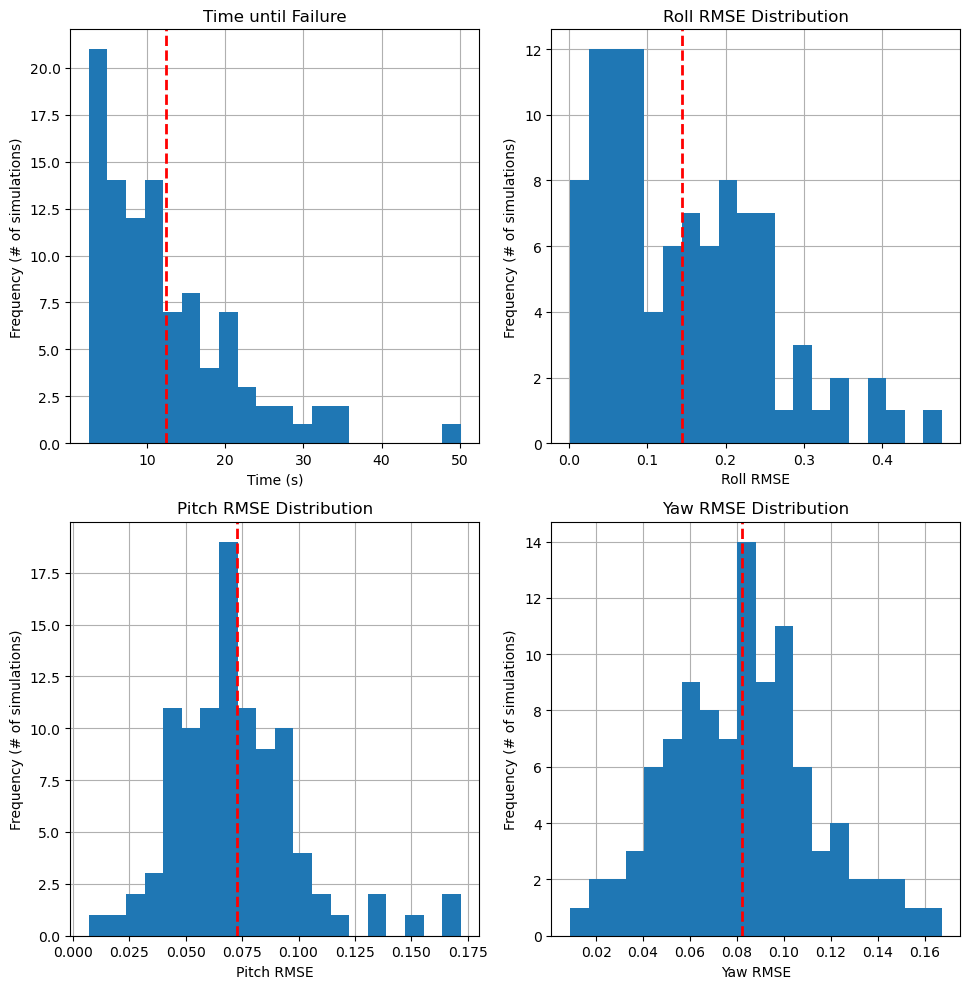

In [123]:
# Setting up the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Adjust the figure size as necessary

mean_time = np.mean(time)
mean_roll = np.mean(roll)
mean_pitch = np.mean(pitch)
mean_yaw = np.mean(yaw)

# Time histogram
axs[0, 0].hist(time, bins=20, zorder=2)
axs[0, 0].axvline(mean_time, color='r', linestyle='dashed', linewidth=2)
axs[0, 0].grid(zorder=0)
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Frequency (# of simulations)')
axs[0, 0].set_title('Time until Failure')

# Roll RMSE histogram
axs[0, 1].hist(roll, bins=20, zorder=2)
axs[0, 1].axvline(mean_roll, color='r', linestyle='dashed', linewidth=2)
axs[0, 1].grid(zorder=0)
axs[0, 1].set_xlabel('Roll RMSE')
axs[0, 1].set_ylabel('Frequency (# of simulations)')
axs[0, 1].set_title('Roll RMSE Distribution')

# Pitch RMSE histogram
axs[1, 0].hist(pitch, bins=20, zorder=2)
axs[1, 0].axvline(mean_pitch, color='r', linestyle='dashed', linewidth=2)
axs[1, 0].grid(zorder=0)
axs[1, 0].set_xlabel('Pitch RMSE')
axs[1, 0].set_ylabel('Frequency (# of simulations)')
axs[1, 0].set_title('Pitch RMSE Distribution')

# Yaw RMSE histogram 
axs[1, 1].hist(yaw, bins=20, zorder=2)
axs[1, 1].axvline(mean_yaw, color='r', linestyle='dashed', linewidth=2)
axs[1, 1].grid(zorder=0)
axs[1, 1].set_xlabel('Yaw RMSE')
axs[1, 1].set_ylabel('Frequency (# of simulations)')
axs[1, 1].set_title('Yaw RMSE Distribution')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [124]:
print("Average Simulation Run Time:", mean_time)
print("Average RMS Roll Error:", mean_roll)
print("Average RMS Pitch Error:", mean_pitch)
print("Average RMS Yaw Error:", mean_yaw)

Average Simulation Run Time: 12.417700000000092
Average RMS Roll Error: 0.144178507524094
Average RMS Pitch Error: 0.07270690221484709
Average RMS Yaw Error: 0.08226086419005732


In [183]:
# Reset the simulator with random initial conditions
sim = ae353_spacecraft.Spacecraft_Sim(use_keyboard=False,
                                      visualization=False,
                                      animation=False,
                                      n_stars=0)
# Initialize the controller
controller.__init__()

# Reset the controller
controller.reset()

# Run the simulation
data = sim.run(controller,
               initial_orientation=[0., 0., 0.],
               initial_ang_vel=[0., 0., 0.],
               sensor_noise=0.1,
               debris=True,
               max_time=240.0)

rollhat = controller.xhat_history["roll"]
pitchhat = controller.xhat_history["pitch"]
yawhat = controller.xhat_history["yaw"]
wxhat = controller.xhat_history["wx"]
wyhat = controller.xhat_history["wy"]
wzhat = controller.xhat_history["wz"]

Wheel 4 speed < -50 rad/s


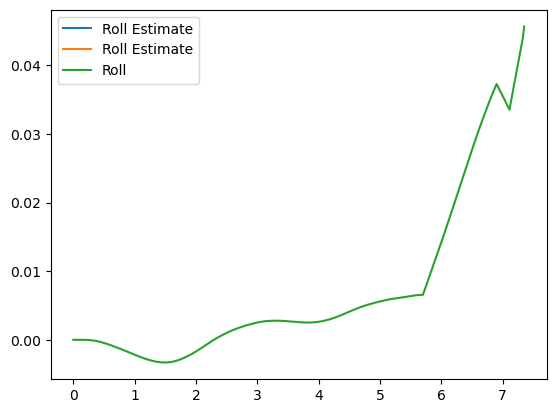

In [86]:
plt.plot(data['time'], rollhat, label='Roll Estimate')
plt.plot(data['time'], data['roll'], label='Roll')
plt.legend()
plt.show()

We start by importing the spacecraft simulation project.

There are four main parameters to the Spacecraft_Sim class initialization function:
#### Parameters

> **use_keyboard** : *bool, optional*  
> A boolean flag that indicates whether the simulation will allow the use of keyboard interactivity. The default is True.
> 
> **visualization** : *bool, optional*  
> A boolean flag that indicates whether the simulation will be  visualized in meshcat. The default is True.
> 
> **animation** : *bool, optional*  
> A boolean flag that indicates whether animated plots are created in real time. The default is True.
>
> **n_stars** : *int, optional*
> The number of background stars to include. Purely visual, has no impact on system dynamics. The default is 20. Large values may slow simulation speed. Large values may look cool.

Now we are ready to run the simulation and collect data. To do this we call the ``sim.run()`` function. This function takes an instance of the ``Controller`` class as an argument and returns ``data``. The parameters and return values of ``sim.run()`` are shown below.

#### Parameters

> **controller** : *member of Controller class*  
> Your controller that will generated inputs to the system.
>
> **initial_orientation** : *Array, shape(3,), optional*  
> The initial orientation to apply to the spacecraft. The initial orientation is applied that the beginning of each simulation and whenever the simulation is reset. The three values in the initial_orientation array are roll, pitch, and yaw. Each value is in radians. Roll is defined as the rotation of the craft about the x-axis of the world coordinate system. Pitch is defined as the rotation of the craft about the y-axis of the world coordinate system. Yaw is defined as the rotation of the craft about the z-axis of the world coordinate system. The default value is [0., 0., 0.].
>
> **initial_ang_vel** : *Array, shape(3,), optional*  
> The initial angular velocity to apply to the spacecraft. The initial angular velocity is applied that the beginning of each simulation and whenever the simulation is reset. The three values in the initial_ang_vel array are wx, wy, and wz. Each value is in radians per second. wx is defined as the rotation rate of the craft about the body-fixed x-axis. wy is defined as the rotation rate of the craft about the body-fixed y-axis. wz is defined as the rotation rate of the craft about the body-fixed z-axis. The default value is [0., 0., 0.].
>  
> **sensor_noise** : *Float, optional*  
> The noise applied to the star tracker, i.e., the standard deviation of the components of each star tracker measurement. The default value is 0.1.
>  
> **debris** : *Bool, optional*  
> A boolean flag that indicates whether or not random space debris will be spawned and strike the spacecraft.
>  
> **max_time** : *Float or None, optional*  
> The total amount of time the simulation is allowed to run. If set to None, the simulation will run until "ESC" is pressed on the keyboard. If the keyboard is disabled, and max_time is set to None, the simulation will automatically terminate after 10 seconds of simulated time. The default value is None.

#### Returns

> **data** : *Dictionary of Lists*  
> A dictionary containing all relevant data generated during the simulation. Specific data is extracted via the statement: data["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys of data for this project are as follows:
>  
> **data["roll"]** : *List of Floats*  
> The roll of the craft in rad at every time stamp in the simulation. Roll is defined as the rotation of the craft about the x-axis of the world coordinate system.
>  
> **data["pitch"]** : *List of Floats*  
> The pitch of the craft in rad at every time stamp in the simulation. Pitch is defined as the rotation of the craft about the y-axis of the world coordinate system.
>  
> **data["yaw"]** : *List of Floats*  
> The yaw of the craft in rad at every time stamp in the simulation. Yaw is defined as the rotation of the craft about the z-axis of the world coordinate system.
>  
> **data["wx"]** : *List of Floats*  
> The angular velocity of the spacecraft about the body-fixed x axis at each time stamp in the simulation. Given in rad/sec.
>  
> **data["wy"]** : *List of Floats*  
> The angular velocity of the spacecraft about the body-fixed y axis at each time stamp in the simulation. Given in rad/sec.
>  
> **data["wz"]** : *List of Floats*  
> The angular velocity of the spacecraft about the body-fixed z axis at each time stamp in the simulation. Given in rad/sec.
>  
> **data["q stars"]** : *List of 2D Coords*  
> A list of the 2D coords of each star in the star-tracker image at each time stamp in the simulation. nan means that the star is not in the star tracker image.e.
>  
> **data["torques"]** : *List of 4 Tuples of Floats*  
> A list of the torques applied to each wheel of the spacecraft in Newton-meters at each time stamp during the simulation. The wheel order is 1, 2, 3, 4.
>  
> **data["wheel speeds"]** : *List of 4 Tuples of Floats*  
> A list of the wheel speeds of each wheel of the spacecraft in rad / sec at each time stamp during the simulation. The wheel order is 1, 2, 3, 4.
>  
> **data["time"]** : *List of Floats*  
> A list of the time stamps in seconds.  

#### If enabled, you can use the keyboard to interact with the simulation:  
> press **ENTER** to start the simulation  
> press **BACKSPACE** to reset the simulation  
> press **SPACE** to pause the simulation  
> press **ESC** to end the simulation  

#### If the manual controller is being used:
> press **a** to apply small negative torque to wheel 1  
> press **q** to apply small positive torque to wheel 1  
> press **s** to apply small negative torque to wheel 2  
> press **w** to apply small positive torque to wheel 2  
> press **d** to apply small negative torque to wheel 3  
> press **e** to apply small positive torque to wheel 3  
> press **f** to apply small negative torque to wheel 4  
> press **r** to apply small positive torque to wheel 4

After the simulation is run, we can plot the data using the Matplotlib package. To start, we import matplotlib and numpy.

Now we can make whichever plots we see fit to make sense of the simulation data. Here we plot the pitch versus time as well as the applied torques versus time.

**THIS IS LEFT INTENTIONALLY AS INSUFFICIENT TO PROVE YOUR CONTROLLER CAN CONTROL THE SPACECRAFT.**

In [190]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the wheel speeds versus time on the first plot
wheel_speeds = np.array(data['wheel speeds'])
axes[0].plot(data['time'], wheel_speeds[:,0], c='k', lw=2.5, label="Wheel 1")
axes[0].plot(data['time'], wheel_speeds[:,1], c='r', lw=2.5, label="Wheel 2")
axes[0].plot(data['time'], wheel_speeds[:,2], c='g', lw=2.5, label="Wheel 3")
axes[0].plot(data['time'], wheel_speeds[:,3], c='b', lw=2.5, label="Wheel 4")
axes[0].set_ylabel("Wheel Speeds [rad / sec]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("Wheel Speed vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torques versus time on the second plot
torques = np.array(data['torques'])
axes[1].plot(data['time'], torques[:,0], c='k', lw=2.5, label="Wheel 1")
axes[1].plot(data['time'], torques[:,1], c='r', lw=2.5, label="Wheel 2")
axes[1].plot(data['time'], torques[:,2], c='g', lw=2.5, label="Wheel 3")
axes[1].plot(data['time'], torques[:,3], c='b', lw=2.5, label="Wheel 4")
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].legend(fontsize=12, shadow=True)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()

In [56]:
#TEST SIM
simtest = ae353_spacecraft.Spacecraft_Sim(use_keyboard=True,
                                      visualization=True,
                                      animation=False,
                                      n_stars=0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [57]:
datatest = simtest.run(controller,
               initial_orientation=[0., 0., 0.],
               initial_ang_vel=[0., 0., 0.],
               sensor_noise=0.1,
               debris=True,
               max_time=240.0)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
RESET
PAUSED
RESUME
RESET
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
RESET
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
Star(s) out of view
Termination command detected. Terminating keyboard listener. Goodbye


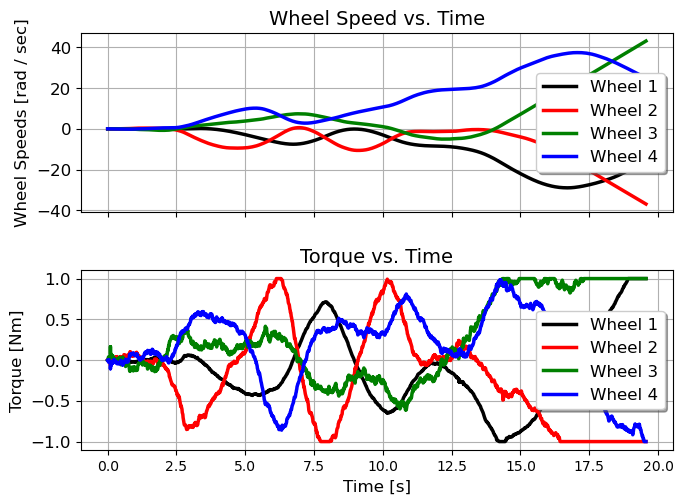

In [58]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the wheel speeds versus time on the first plot
wheel_speeds = np.array(datatest['wheel speeds'])
axes[0].plot(datatest['time'], wheel_speeds[:,0], c='k', lw=2.5, label="Wheel 1")
axes[0].plot(datatest['time'], wheel_speeds[:,1], c='r', lw=2.5, label="Wheel 2")
axes[0].plot(datatest['time'], wheel_speeds[:,2], c='g', lw=2.5, label="Wheel 3")
axes[0].plot(datatest['time'], wheel_speeds[:,3], c='b', lw=2.5, label="Wheel 4")
axes[0].set_ylabel("Wheel Speeds [rad / sec]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("Wheel Speed vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torques versus time on the second plot
torques = np.array(datatest['torques'])
axes[1].plot(datatest['time'], torques[:,0], c='k', lw=2.5, label="Wheel 1")
axes[1].plot(datatest['time'], torques[:,1], c='r', lw=2.5, label="Wheel 2")
axes[1].plot(datatest['time'], torques[:,2], c='g', lw=2.5, label="Wheel 3")
axes[1].plot(datatest['time'], torques[:,3], c='b', lw=2.5, label="Wheel 4")
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].legend(fontsize=12, shadow=True)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()